In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.fetch_files_from_runs import fetch_files_from_runs
import os
import pandas as pd
import pickle
import shutil
algos = ["acdc", "legacy", "node_sp", "edge_sp", "eap", "integrated_grad"]

In [3]:
for folder in os.listdir("./results/"):
    if any([algo in folder for algo in algos]):
        print(f"Removing {folder}")
        shutil.rmtree(f"./results/{folder}")

Removing integrated_grad
Removing eap
Removing acdc
Removing node_sp
Removing edge_sp


In [4]:
project = "circuit_discovery"
group = "interp_bench"
files_to_fetch = ["result.pkl"]
fetch_files_from_runs(project, group=group, files_to_download=files_to_fetch)

100%|██████████| 1635/1635 [00:47<00:00, 34.14it/s] 


## Analyse

In [5]:
import iit.model_pairs as mp

def append_row(table, row):
    return pd.concat([
                table, 
                pd.DataFrame([row], columns=row.index)]
        ).reset_index(drop=True)

def get_results_for_case_algo(algo):
    root_dir = f"results/{algo}"
    df = pd.DataFrame(columns = ["run", "threshold", "node_tpr", "node_fpr", "edge_tpr", "edge_fpr"])
    for run in os.listdir(root_dir):
        run_dir = root_dir + "/" + run + "/" + "interp_bench"
        for threshold in os.listdir(run_dir):
            with open(run_dir + "/" + threshold + "/result.pkl", "rb") as f:
                result = pickle.load(f)
            threshold_num = float(threshold.split("_")[-1])
            entry = {"run": run, 
                     "threshold": threshold_num, 
                     "node_tpr": result.nodes.tpr, 
                     "node_fpr": result.nodes.fpr, 
                     "edge_tpr": result.edges.tpr, 
                     "edge_fpr": result.edges.fpr
                    }
            df = append_row(df, pd.Series(entry))
    return df

acdc_scores = get_results_for_case_algo("acdc")
node_sp_scores = get_results_for_case_algo("node_sp")
edge_sp_scores = get_results_for_case_algo("edge_sp")
eap_scores = get_results_for_case_algo("eap")
integrated_grads_scores = get_results_for_case_algo("integrated_grad")

/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_59213/2038028330.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_59213/2038028330.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_59213/2038028330.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this

In [6]:
# from utils.plotter import pessimistic_auc as auc
# from sklearn.metrics import 
from interp_utils.circuit_discovery.pessimistic_roc import pessimistic_auc, make_monotonically_increasing
import numpy as np

def get_ROCs(scores: pd.DataFrame, algorithm: str):
    if algorithm in ["acdc", "eap", "integrated_grad"]:
        sort_key = "threshold"
        ascending = False
    elif "sp" in algorithm:
        sort_key = "threshold"
        ascending = True
    rocs = {} # run : {node: node_roc, edge: edge_roc}
    scores_by_run = scores.groupby("run")
    for run, run_scores in scores_by_run:
        run_scores = run_scores.sort_values(by=sort_key, ascending=ascending)
        # get 'node_tpr', 'node_fpr', 'edge_tpr', 'edge_fpr' from run_scores
        node_fpr = list(run_scores["node_fpr"].values.copy())
        node_tpr = list(run_scores["node_tpr"].values.copy())
        edge_fpr = list(run_scores["edge_fpr"].values.copy())
        edge_tpr = list(run_scores["edge_tpr"].values.copy())
        # print(node_fpr, node_tpr)
        # make fpr and tpr lists monotonic
        def get_xy(xs, ys):
            xs, ys, removed_xs, removed_ys = make_monotonically_increasing(xs, ys)
            xs = np.concatenate([[0], xs, [1]])
            ys = np.concatenate([[0], ys, [1]])
            return xs, ys
        
        node_fpr, node_tpr = get_xy(node_fpr, node_tpr)
        edge_fpr, edge_tpr = get_xy(edge_fpr, edge_tpr)
        
        # calculate roc_auc for node and edge
        try:
            node_roc = pessimistic_auc(node_fpr, node_tpr)
            edge_roc = pessimistic_auc(edge_fpr, edge_tpr)
        except Exception as e:
            print(f"error in run {run}, for {algorithm}")
            print(e)
            continue
        rocs[run] = {"node": node_roc, "edge": edge_roc}
    return rocs

In [7]:
# make 2 combined dataframes: one for node_roc and one for edge_roc

def get_combined_roc_df_from_list(list_of_rocs, list_of_names):
    node_roc_df = pd.DataFrame()
    edge_roc_df = pd.DataFrame()

    for k, v in list_of_rocs[0].items():
        run = k
        node_roc = v["node"]
        edge_roc = v["edge"]
        node_entry = {"run": run, list_of_names[0]: node_roc}
        edge_entry = {"run": run, list_of_names[0]: edge_roc}
        for i, rocs in enumerate(list_of_rocs[1:]):
            try:
                node_roc = rocs[k]["node"]
                edge_roc = rocs[k]["edge"]
            except:
                continue
            node_entry[list_of_names[i+1]] = node_roc
            edge_entry[list_of_names[i+1]] = edge_roc
        node_roc_df = append_row(node_roc_df, pd.Series(node_entry))
        edge_roc_df = append_row(edge_roc_df, pd.Series(edge_entry))

    return node_roc_df, edge_roc_df

In [8]:
# drop rows with N/A values
def get_na_rows(df):
    runs = []
    for row in df.iterrows():
        if row[1].isna().any() or 'N/A' in row[1].values:
            # df = df.drop(row[0])
            runs.append(row[1]["run"])
    return set(runs)

runs = get_na_rows(eap_scores)
runs

set()

In [9]:
acdc_rocs = get_ROCs(acdc_scores, "acdc")
node_sp_rocs = get_ROCs(node_sp_scores, "node_sp")
edge_sp_rocs = get_ROCs(edge_sp_scores, "edge_sp")
eap_rocs = get_ROCs(eap_scores, "eap")
integrated_grad_rocs = get_ROCs(integrated_grads_scores, "integrated_grad")
algo_rocs = [acdc_rocs, node_sp_rocs, edge_sp_rocs, eap_rocs, integrated_grad_rocs]

In [10]:
node_roc_df, edge_roc_df = get_combined_roc_df_from_list(algo_rocs, algos)
# remove ioi row from the dataframes
node_roc_df = node_roc_df[node_roc_df.run != "ioi"]
edge_roc_df = edge_roc_df[edge_roc_df.run != "ioi"]
node_roc_df.to_csv("/Users/cybershiptrooper/Desktop/node_roc_df.csv")
edge_roc_df.to_csv("/Users/cybershiptrooper/Desktop/edge_roc_df.csv")
# replace underscores with spaces in column names
node_roc_df.columns = [col.replace("_", " ") for col in node_roc_df.columns]
node_roc_df.columns = [col.replace("integrated grad", "eap ig-10") for col in node_roc_df.columns]
edge_roc_df.columns = [col.replace("_", " ") for col in edge_roc_df.columns]
edge_roc_df.columns = [col.replace("integrated grad", "eap ig-10") for col in edge_roc_df.columns]

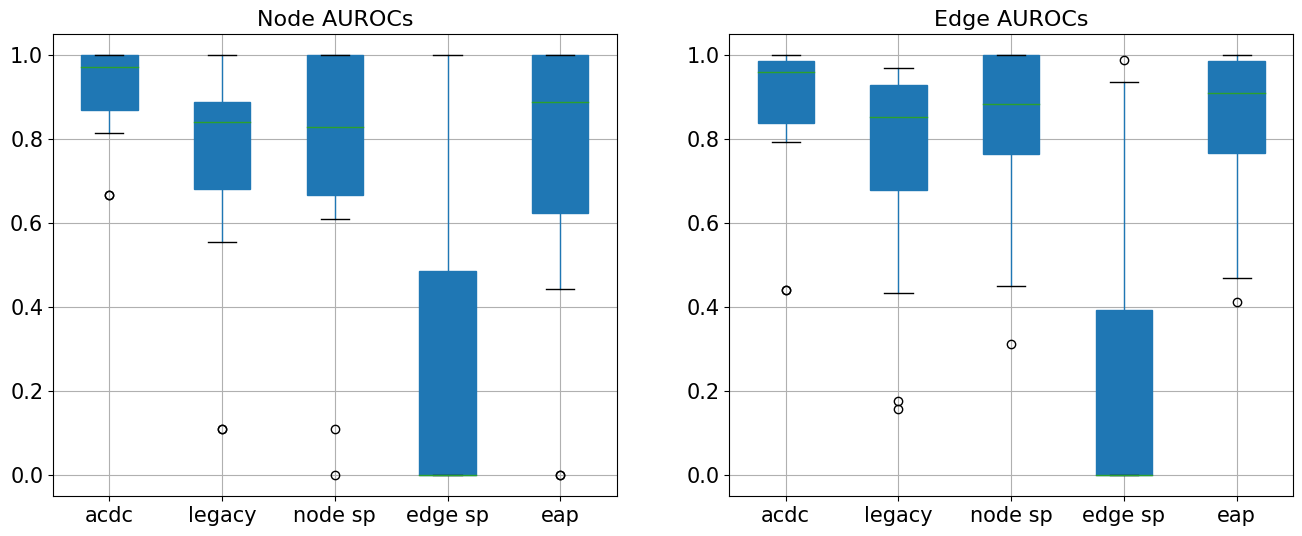

In [11]:
# make box plots for node and edge roc_auc
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

node_roc_df.boxplot(ax=ax[0], 
                    column=node_roc_df.columns[1:].tolist(),
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
edge_roc_df.boxplot(ax=ax[1],
                    column=edge_roc_df.columns[1:].tolist(),
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# set title
ax[0].set_title("Node AUROCs", fontsize=16)
ax[1].set_title("Edge AUROCs", fontsize=16)

# font size
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

plt.savefig("plots/circuit_discovery_auc_boxplot.pdf", bbox_inches='tight', dpi=600, format='pdf')

In [12]:
# subtract acdc column from all other columns
def subtract_acdc(df):
    columns = df.columns.to_list()
    columns.remove("acdc")
    ans_df = pd.DataFrame(columns=columns)
    for col in df.columns:
        if col == "run":
            ans_df[col] = df[col]
            continue
        if col == "acdc":
            continue
        ans_df[col] = df[col] - df["acdc"]
    return ans_df

node_roc_df_minus_acdc = subtract_acdc(node_roc_df)
edge_roc_df_minus_acdc = subtract_acdc(edge_roc_df)

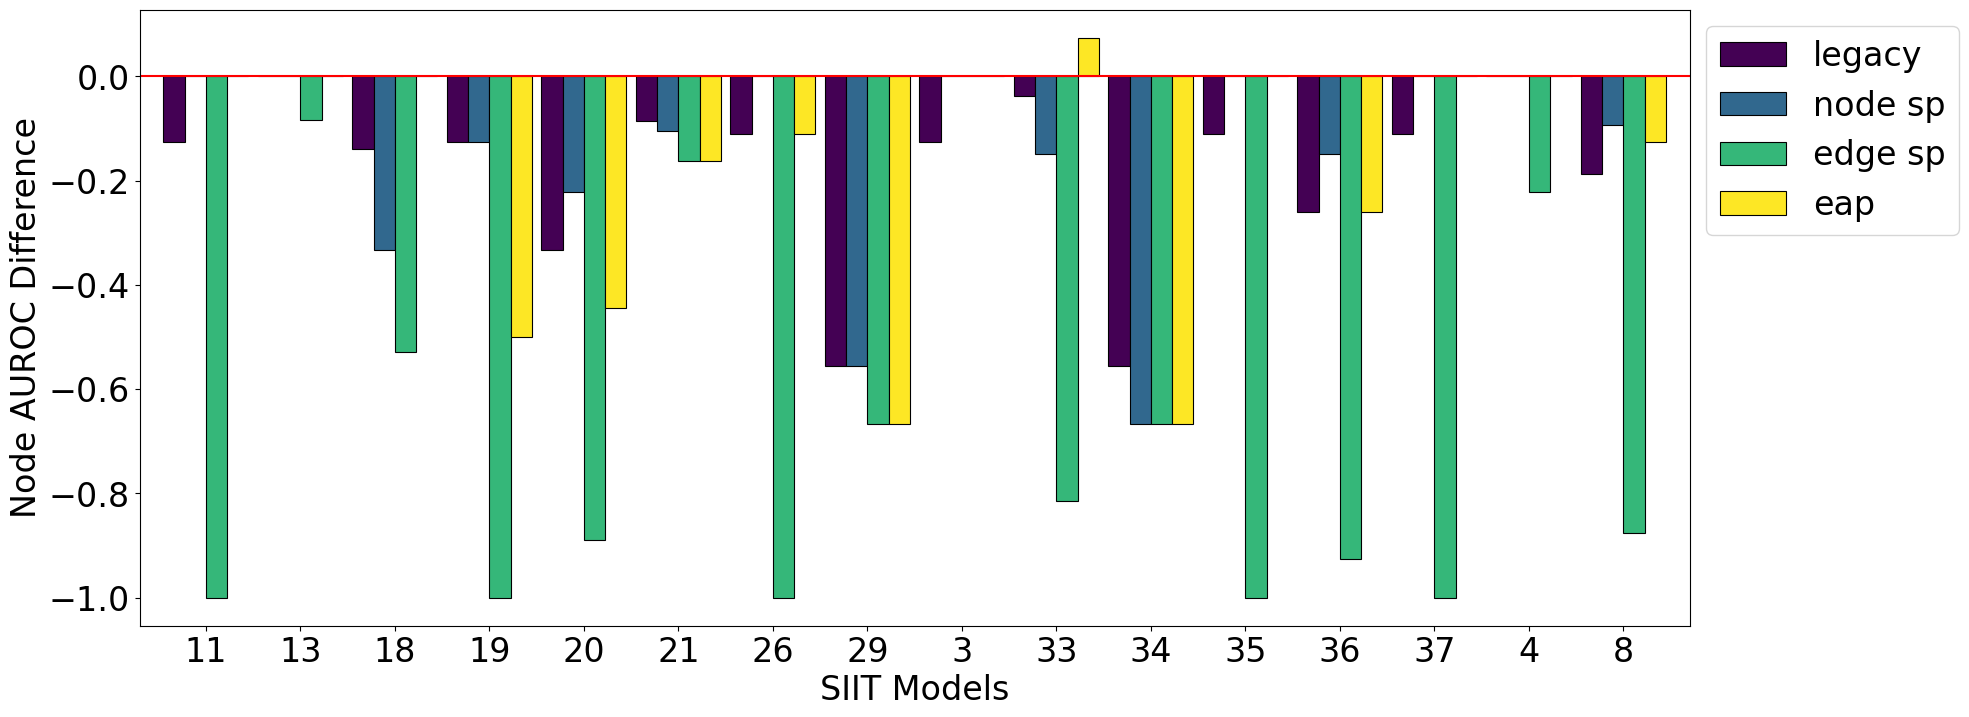

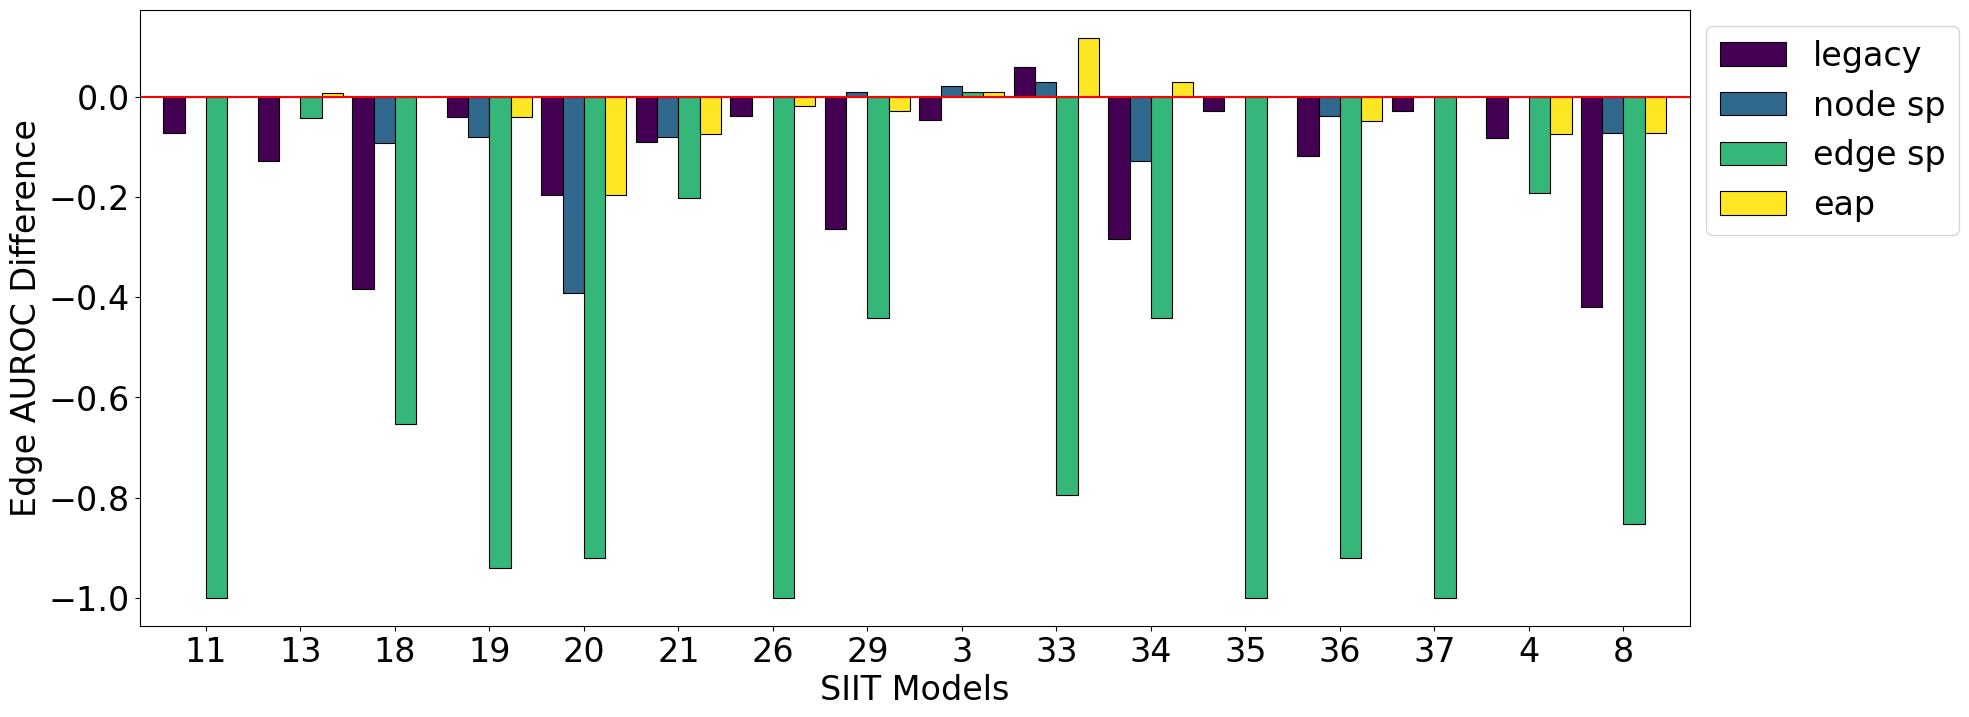

In [24]:
fig1, ax1 = plt.subplots(1, 1, figsize=(20, 8))
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 8))
# plot 0 line
ax1.axhline(0, color='red', linestyle='-')
ax2.axhline(0, color='red', linestyle='-')

# node_roc_df_minus_acdc.boxplot(ax=ax1[0],
#                     column=node_roc_df_minus_acdc.columns[1:].tolist(),
#                     patch_artist=True,
#                     showfliers=True,
#                     # whis=[5, 95],
#                     )
# edge_roc_df_minus_acdc.boxplot(ax=ax2[0],
#                     column=edge_roc_df_minus_acdc.columns[1:].tolist(),
#                     patch_artist=True,
#                     showfliers=True,
#                     # whis=[5, 95],
#                     )

# bar plot for node_roc_df_minus_acdc and edge_roc_df_minus_acdc side by side
cmap = "viridis"
node_roc_df_minus_acdc.plot(kind='bar', ax=ax1, width=0.9, colormap=cmap,
                            # make border
                            edgecolor='black', linewidth=0.8)
edge_roc_df_minus_acdc.plot(kind='bar', ax=ax2, width=0.9, colormap=cmap,
                            # make border
                            edgecolor='black', linewidth=0.8)

# font size
# ax1[0].tick_params(axis='both', which='major', labelsize=18, rotation=0)
# ax2[0].tick_params(axis='both', which='major', labelsize=18, rotation=0)

# plot 0 line
# ax1[0].axhline(0, color='red', linestyle='--')
# ax2[0].axhline(0, color='red', linestyle='--')

ax1.tick_params(axis='both', which='major', labelsize=24, rotation=0)
ax2.tick_params(axis='both', which='major', labelsize=24, rotation=0)

# set labels as run numbers
ax1.set_xticklabels(node_roc_df_minus_acdc["run"])
ax2.set_xticklabels(edge_roc_df_minus_acdc["run"])


# set y limits
# ax1.set_ylim(-1, 0.05)

# set y label
# ax1[0].set_ylabel("Node AUROC Difference", fontsize=18)
# ax2[0].set_ylabel("Edge AUROC Difference", fontsize=18)
ax1.set_ylabel("Node AUROC Difference", fontsize=24)
ax2.set_ylabel("Edge AUROC Difference", fontsize=24)
ax1.set_xlabel("SIIT Models", fontsize=24)
ax2.set_xlabel("SIIT Models", fontsize=24)
# set legend outside the plot
ax1.legend(fontsize=24, 
           bbox_to_anchor=(1.0, 1), 
           loc='upper left')
ax2.legend(fontsize=24, 
           bbox_to_anchor=(1.0, 1), 
           loc='upper left')
# ax1[0].set_xlabel("Algorithms", fontsize=18)
# ax2[0].set_xlabel("Algorithms", fontsize=18)



# plt.savefig("plots/circuit_discovery_auc_boxplot_minus_acdc.pdf", bbox_inches='tight', dpi=600, format='pdf')
fig1.savefig("plots/circuit_discovery_node_auc_minus_acdc.pdf", bbox_inches='tight', dpi=600, format='pdf')
fig2.savefig("plots/circuit_discovery_edge_auc_minus_acdc.pdf", bbox_inches='tight', dpi=600, format='pdf')


In [14]:
print(node_roc_df.get(node_roc_df["run"] == "33"))
print(edge_roc_df.get(edge_roc_df["run"] == "33"))

  run      acdc    legacy   node sp  edge sp       eap
9  33  0.814815  0.777778  0.666667      0.0  0.888889
  run      acdc    legacy   node sp  edge sp       eap
9  33  0.794118  0.852941  0.823529      0.0  0.911765


In [15]:

import pickle
algo = "integrated_grad"
# algo = "acdc"
run = "36"
with open(f"results/{algo}/{run}/interp_bench/threshold_100.0/result.pkl", "rb") as f:
    result = pickle.load(f)

In [16]:
(len(result.edges.true_positive), len(result.edges.false_positive), len(result.edges.true_negative), len(result.edges.false_negative)), (len(result.nodes.true_positive), len(result.nodes.false_positive), len(result.nodes.true_negative), len(result.nodes.false_negative))

((2, 15, 36, 0), (3, 8, 1, 0))

In [17]:
result.edges.tpr, result.edges.fpr, result.nodes.tpr, result.nodes.fpr

(1.0, 0.29411764705882354, 1.0, 0.8888888888888888)

In [18]:
node_roc_df.groupby("run").get_group("33")

,run,acdc,legacy,node sp,edge sp,eap
9,33,0.814815,0.777778,0.666667,0.0,0.888889


In [19]:
edge_roc_df.groupby("run").get_group("33")

,run,acdc,legacy,node sp,edge sp,eap
9,33,0.794118,0.852941,0.823529,0.0,0.911765


### Is IOI next token more difficult?

In [20]:
# ioi_row = node_roc_df.groupby("run").get_group("ioi")
# ioi_next_token_row = node_roc_df.groupby("run").get_group("ioi_next_token")

# # scatter plot both of them 
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].scatter(x=algos, y=ioi_row[algos].values, label="ioi")
# ax[0].scatter(x=algos, y=ioi_next_token_row[algos].values, label="ioi_next_token")
# ax[0].set_title("Node ROC AUC")
# ax[0].legend()

# ioi_row = edge_roc_df.groupby("run").get_group("ioi")
# ioi_next_token_row = edge_roc_df.groupby("run").get_group("ioi_next_token")

# # scatter plot both of them
# ax[1].scatter(x=algos, y=ioi_row[algos].values, label="ioi")
# ax[1].scatter(x=algos, y=ioi_next_token_row[algos].values, label="ioi_next_token")
# ax[1].set_title("Edge ROC AUC")
# ax[1].legend()
# # plt.savefig("plots/ioi_vs_ioi_next_token_node_edge_roc_auc_scatter.pdf", bbox_inches='tight', dpi=600, format='pdf')

In [21]:
# bruh- they're the same models 
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
from circuits_benchmark.utils.get_cases import get_cases
import torch

cases = get_cases(indices=["ioi", "ioi_next_token"])
ll_model_loader = get_ll_model_loader(cases[0], interp_bench=True)
corr, model = ll_model_loader.load_ll_model_and_correspondence(device="cpu")
ll_model_loader = get_ll_model_loader(cases[1], interp_bench=True)
corr2, model2 = ll_model_loader.load_ll_model_and_correspondence(device="cpu")
# check if both models have same weights

for p1, p2 in zip(model.parameters(), model2.parameters()):
    assert torch.all(p1 == p2) 